<a href="https://colab.research.google.com/github/LawsonHutter/RNN_working_memory/blob/main/RNN_working_memory_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [328]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [329]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [330]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

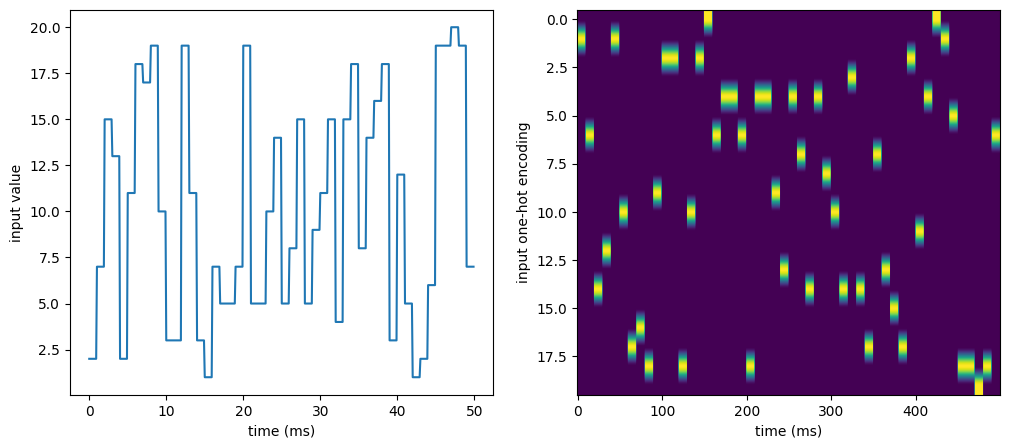

In [331]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

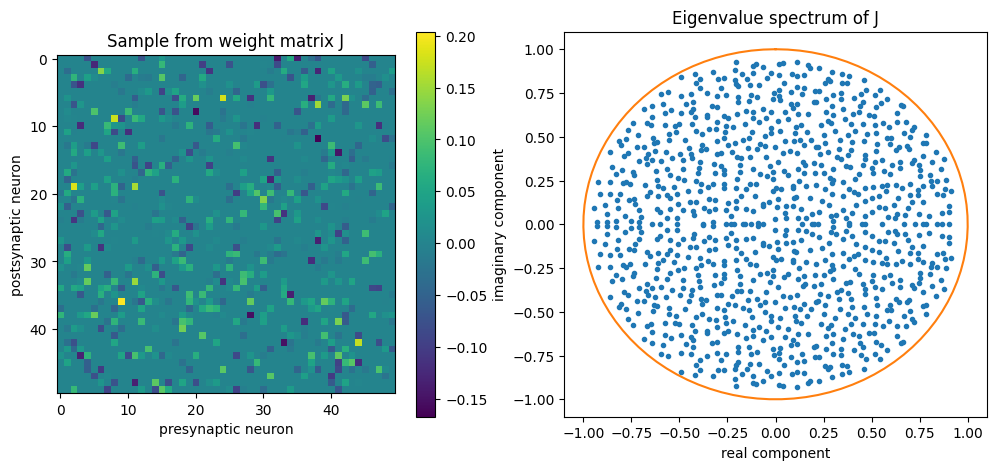

In [249]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

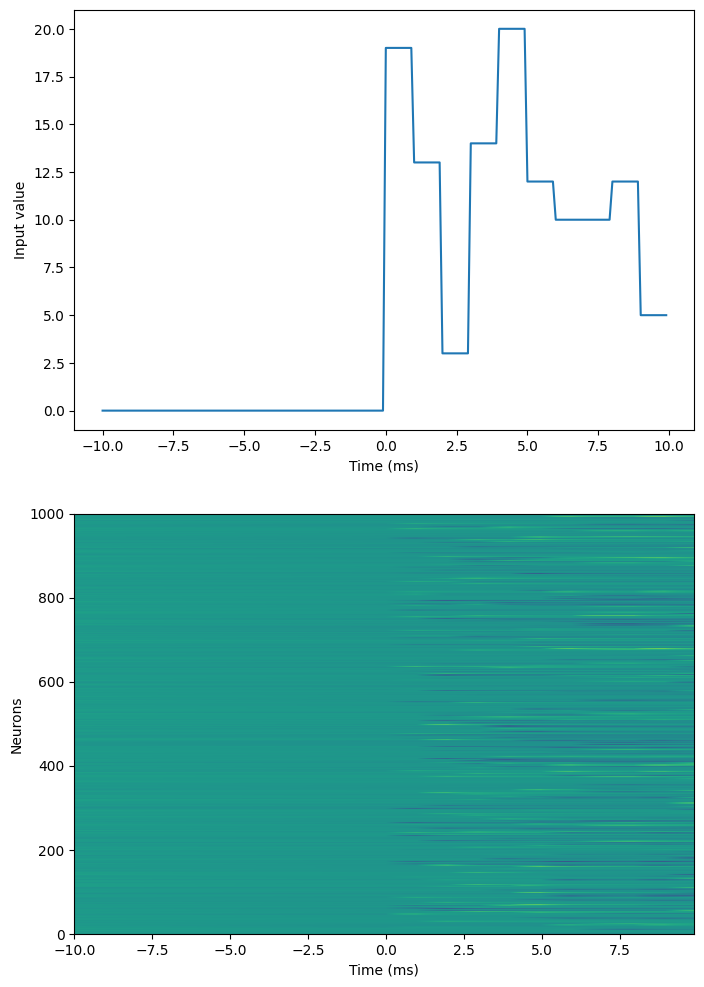

In [275]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [332]:
# Our Imports
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed

# Q1)

In [333]:
# Generate Data (1 Set)
sequence_length = 10
onehot, inputs = make_input(sequence_length, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(inputs)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']

# Set to numpy
input_set = np.array(inputs)
firing_set = np.array(firing_rates.T)

In [334]:
# Determin X value and restructure data accordingly
max_X = 5

# New data sets for each x
input_sets_X = []
firing_sets_X = []

# Restructure Data
for x in range(1, max_X+1):
  # Delete the first x input sets and last x firing rates sets
  input_set_temp = input_set[x:]
  firing_rates_set_temp = firing_set[:-(x), :]

  input_sets_X.append(input_set_temp)
  firing_sets_X.append(firing_rates_set_temp)

In [340]:
# Train Test Split
targets_train_Y = []
firing_rates_train_X = []
targets_test_Y = []
firing_rates_test_X = []

for i in range(0, max_X):
  X_train, X_test, y_train, y_test = train_test_split(firing_sets_X[i], input_sets_X[i], test_size=0.2, random_state=42)

  firing_rates_train_X.append(X_train)
  firing_rates_test_X.append(X_test)
  targets_train_Y.append(y_train)
  targets_test_Y.append(y_test)

In [342]:
print(firing_rates_train_X[0].shape)
print(firing_rates_test_X[0].shape)
print(targets_train_Y[0].shape)
print(targets_test_Y[0].shape)

(159, 1000)
(40, 1000)
(159,)
(40,)


In [337]:
# Create a list to store the models
models = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)

# Loop over the range of x values
for x in range(1, max_X+1):
    
    # Define the model
    model = Sequential()

    # Add a SimpleRNN layer with 128 hidden units and g parameter
    g = K.variable(1.0, name="g")
    model.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform',
                        recurrent_regularizer=lambda x: K.sum(g * K.square(x)), 
                        name="rnn"))

    # Add a Dense output layer with a single unit
    model.add(Dense(1))

    # Compile the model with mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models.append(model)

In [338]:
# Train the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_train = firing_rates_train_X[x]
    targets_train = targets_train_Y[x]

    # Reshape data
    firing_rates_train = firing_rates_train.reshape(firing_rates_train.shape[0], 1, 1000)
    targets_train = targets_train.reshape(targets_train.shape[0], 1)

    
    # Train the model on the firing rates and targets
    model = models[x-1]
    model.fit(firing_rates_train, targets_train, epochs=100, batch_size=32, callbacks=[early_stop])

    # Save the model as a pickle file with a subscript of its x value
    #filename = f'model_{x}.pickle'
    #with open(filename, 'wb') as f:
    #    pickle.dump(model, f)


Epoch 1/100
5/5 [==============================] - 2s 11ms/step - loss: 193.4633
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 151.4286
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 126.6992
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 110.7818
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 98.0816
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 86.7494
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 77.7171
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 70.4120
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 63.9285
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 57.8661
Epoch 11/100
5/5 [==============================] - 0s 9ms/step - loss: 52.4081
Epoch 12/100
5/5 [==============================] - 0s 10ms/step - loss: 47.4932
Epoch 13/100
5/5 [==================

2/2 [==============================] - 0s 8ms/step
Model 0: MSE = 6.9802, R-squared = 0.8182


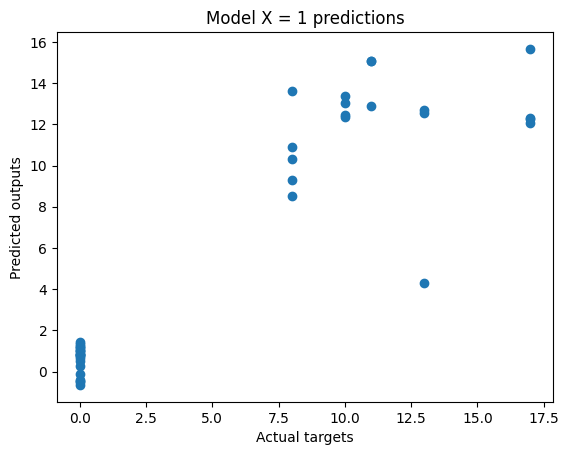

2/2 [==============================] - 0s 10ms/step
Model 1: MSE = 6.1375, R-squared = 0.8750


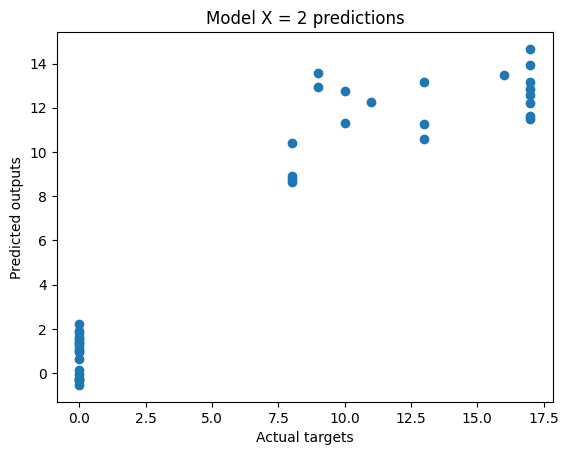

2/2 [==============================] - 0s 8ms/step
Model 2: MSE = 4.7988, R-squared = 0.8943


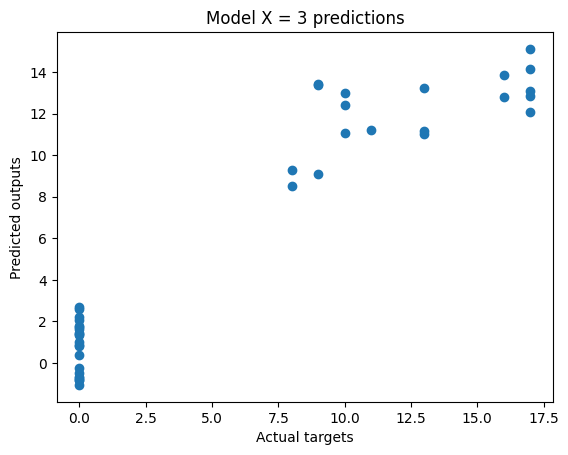

2/2 [==============================] - 0s 8ms/step
Model 3: MSE = 5.8592, R-squared = 0.8803


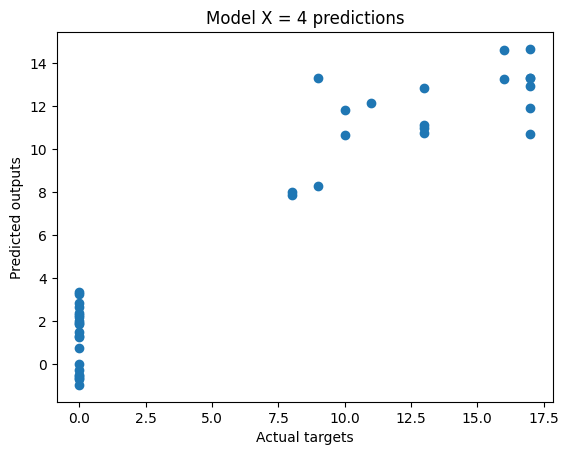

2/2 [==============================] - 0s 13ms/step
Model 4: MSE = 7.7733, R-squared = 0.8231


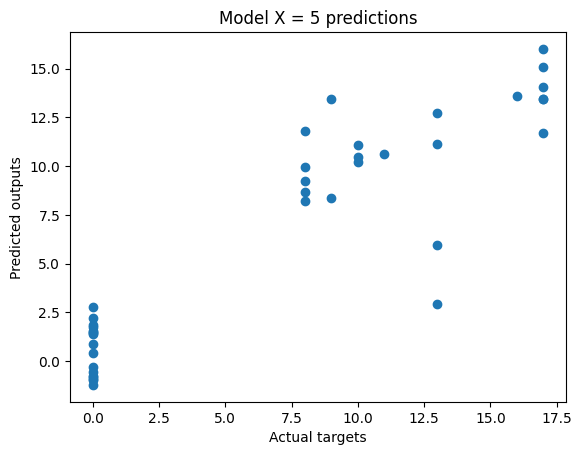

In [347]:
# Test the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_test = firing_rates_test_X[x]
    targets_test = targets_test_Y[x]

    # Reshape data
    firing_rates_test= firing_rates_test.reshape(firing_rates_test.shape[0], 1, 1000)
    targets_test = targets_test.reshape(targets_test.shape[0], 1)

    # Load the saved model for this value of x
    model = models[x-1]

    # Predict the outputs for the test set
    predictions = model.predict(firing_rates_test)

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(targets_test, predictions)
    r2 = r2_score(targets_test, predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

    # Plot the predicted outputs against the actual targets
    plt.figure()
    plt.scatter(targets_test, predictions)
    plt.xlabel('Actual targets')
    plt.ylabel('Predicted outputs')
    plt.title(f'Model X = {x+1} predictions')
    plt.show()

# Q2)

In [349]:
# Create a list to store the models
models_g2 = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)

# Loop over the range of x values
for x in range(1, max_X+1):
    
    # Define the model
    model = Sequential()

    # Add a SimpleRNN layer with 128 hidden units and g parameter
    g = K.variable(2.0, name="g")
    model.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform',
                        recurrent_regularizer=lambda x: K.sum(g * K.square(x)), 
                        name="rnn"))

    # Add a Dense output layer with a single unit
    model.add(Dense(1))

    # Compile the model with mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models_g2.append(model)

In [351]:
# Train the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_train = firing_rates_train_X[x]
    targets_train = targets_train_Y[x]

    # Reshape data
    firing_rates_train = firing_rates_train.reshape(firing_rates_train.shape[0], 1, 1000)
    targets_train = targets_train.reshape(targets_train.shape[0], 1)

    
    # Train the model on the firing rates and targets
    model = models_g2[x-1]
    model.fit(firing_rates_train, targets_train, epochs=100, batch_size=32, callbacks=[early_stop])

    # Save the model as a pickle file with a subscript of its x value
    #filename = f'model_{x}.pickle'
    #with open(filename, 'wb') as f:
    #    pickle.dump(model, f)


Epoch 1/100
5/5 [==============================] - 1s 10ms/step - loss: 557.0171
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 481.6252
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 423.9559
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 378.9667
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 338.8811
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 302.5716
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 270.6750
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 242.8423
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 217.7041
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 194.7446
Epoch 11/100
5/5 [==============================] - 0s 7ms/step - loss: 174.0580
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 155.5432
Epoch 13/100
5/5 [==================

2/2 [==============================] - 0s 16ms/step
Model 1: MSE = 6.9805, R-squared = 0.8182


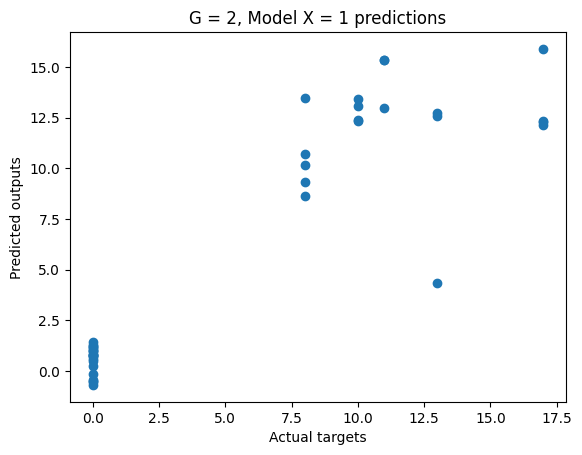

2/2 [==============================] - 0s 18ms/step
Model 2: MSE = 6.1779, R-squared = 0.8742


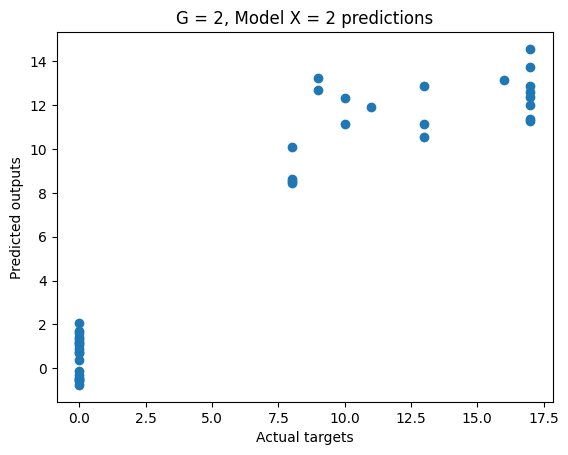

2/2 [==============================] - 0s 10ms/step
Model 3: MSE = 4.7375, R-squared = 0.8956


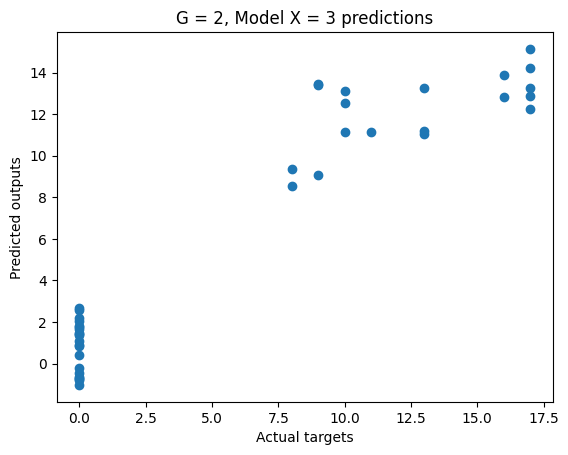

2/2 [==============================] - 0s 9ms/step
Model 4: MSE = 5.6910, R-squared = 0.8837


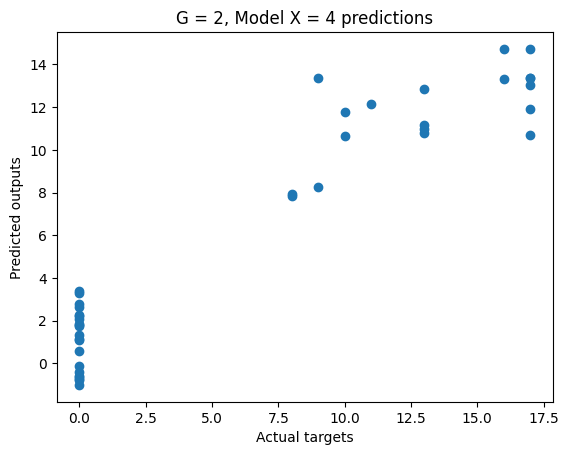

2/2 [==============================] - 0s 7ms/step
Model 5: MSE = 7.5827, R-squared = 0.8274


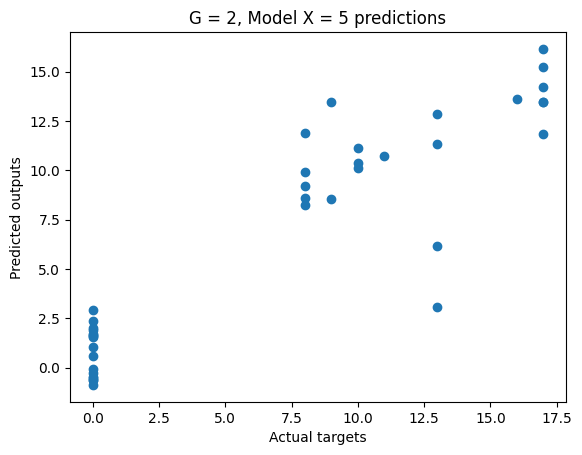

In [353]:
# Test the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_test = firing_rates_test_X[x]
    targets_test = targets_test_Y[x]

    # Reshape data
    firing_rates_test= firing_rates_test.reshape(firing_rates_test.shape[0], 1, 1000)
    targets_test = targets_test.reshape(targets_test.shape[0], 1)

    # Load the saved model for this value of x
    model = models_g2[x-1]

    # Predict the outputs for the test set
    predictions = model.predict(firing_rates_test)

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(targets_test, predictions)
    r2 = r2_score(targets_test, predictions)
    print(f'Model {x+1}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

    # Plot the predicted outputs against the actual targets
    plt.figure()
    plt.scatter(targets_test, predictions)
    plt.xlabel('Actual targets')
    plt.ylabel('Predicted outputs')
    plt.title(f'G = 2, Model X = {x+1} predictions')
    plt.show()

In [354]:
# Create a list to store the models
models_g4 = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)

# Loop over the range of x values
for x in range(1, max_X+1):
    
    # Define the model
    model = Sequential()

    # Add a SimpleRNN layer with 128 hidden units and g parameter
    g = K.variable(4.0, name="g")
    model.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform',
                        recurrent_regularizer=lambda x: K.sum(g * K.square(x)), 
                        name="rnn"))

    # Add a Dense output layer with a single unit
    model.add(Dense(1))

    # Compile the model with mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models_g4.append(model)

In [355]:
# Train the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_train = firing_rates_train_X[x]
    targets_train = targets_train_Y[x]

    # Reshape data
    firing_rates_train = firing_rates_train.reshape(firing_rates_train.shape[0], 1, 1000)
    targets_train = targets_train.reshape(targets_train.shape[0], 1)

    
    # Train the model on the firing rates and targets
    model = models_g4[x-1]
    model.fit(firing_rates_train, targets_train, epochs=100, batch_size=32, callbacks=[early_stop])

    # Save the model as a pickle file with a subscript of its x value
    #filename = f'model_{x}.pickle'
    #with open(filename, 'wb') as f:
    #    pickle.dump(model, f)


Epoch 1/100
5/5 [==============================] - 1s 10ms/step - loss: 562.4034
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 485.2255
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 428.0684
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 381.8916
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 341.3599
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 304.9754
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 272.6203
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 244.6167
Epoch 9/100
5/5 [==============================] - 0s 9ms/step - loss: 219.3793
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 196.2342
Epoch 11/100
5/5 [==============================] - 0s 9ms/step - loss: 175.5672
Epoch 12/100
5/5 [==============================] - 0s 9ms/step - loss: 156.8967
Epoch 13/100
5/5 [==============

2/2 [==============================] - 0s 6ms/step
Model 1: MSE = 7.1689, R-squared = 0.8133


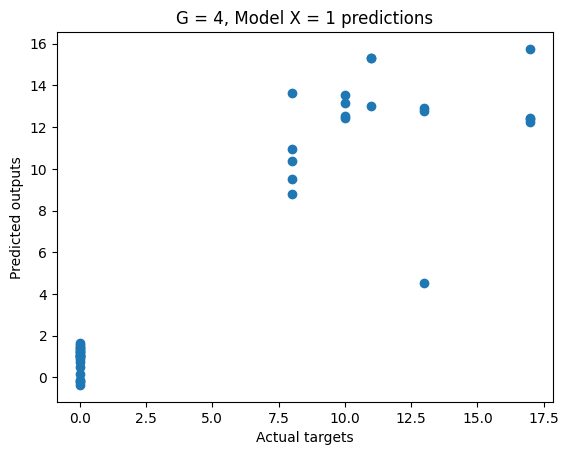

2/2 [==============================] - 0s 13ms/step
Model 2: MSE = 6.1042, R-squared = 0.8757


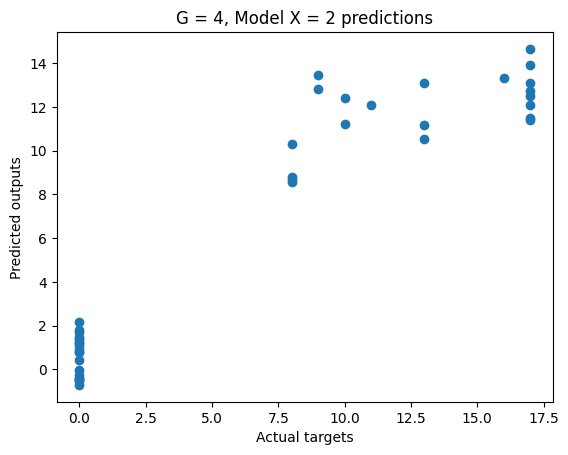

2/2 [==============================] - 0s 6ms/step
Model 3: MSE = 5.5775, R-squared = 0.8771


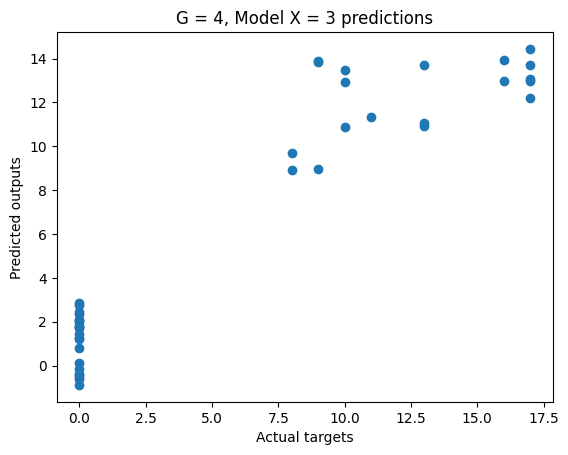

2/2 [==============================] - 0s 6ms/step
Model 4: MSE = 5.5981, R-squared = 0.8856


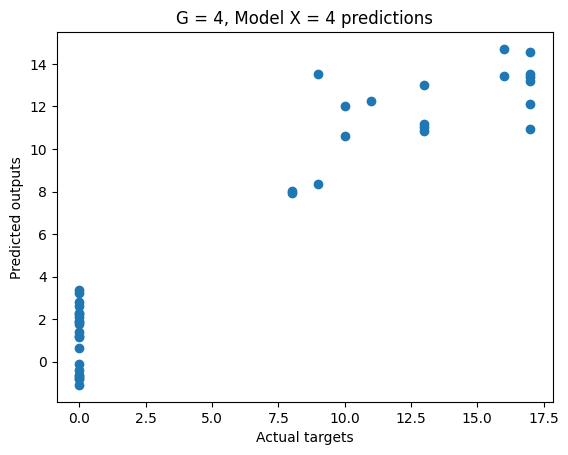

2/2 [==============================] - 0s 11ms/step
Model 5: MSE = 7.7334, R-squared = 0.8240


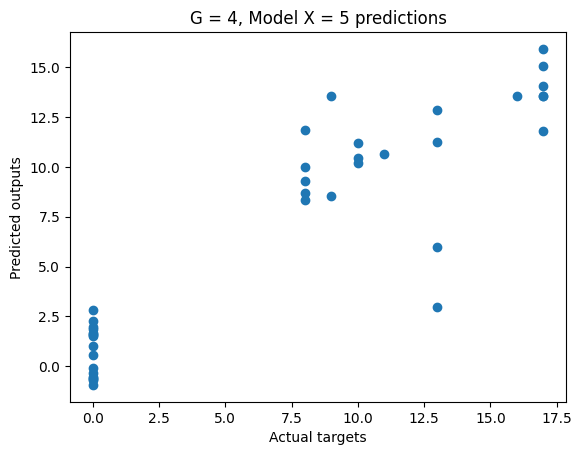

In [356]:
# Test the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_test = firing_rates_test_X[x]
    targets_test = targets_test_Y[x]

    # Reshape data
    firing_rates_test= firing_rates_test.reshape(firing_rates_test.shape[0], 1, 1000)
    targets_test = targets_test.reshape(targets_test.shape[0], 1)

    # Load the saved model for this value of x
    model = models_g4[x-1]

    # Predict the outputs for the test set
    predictions = model.predict(firing_rates_test)

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(targets_test, predictions)
    r2 = r2_score(targets_test, predictions)
    print(f'Model {x+1}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

    # Plot the predicted outputs against the actual targets
    plt.figure()
    plt.scatter(targets_test, predictions)
    plt.xlabel('Actual targets')
    plt.ylabel('Predicted outputs')
    plt.title(f'G = 4, Model X = {x+1} predictions')
    plt.show()

In [363]:
# Create a list to store the models
models_g8 = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)

# Loop over the range of x values
for x in range(1, max_X+1):
    
    # Define the model
    model = Sequential()

    # Add a SimpleRNN layer with 128 hidden units and g parameter
    g = K.variable(8.0, name="g")
    model.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform',
                        recurrent_regularizer=lambda x: K.sum(g * K.square(x)), 
                        name="rnn"))

    # Add a Dense output layer with a single unit
    model.add(Dense(1))

    # Compile the model with mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models_g8.append(model)

In [364]:
# Train the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_train = firing_rates_train_X[x]
    targets_train = targets_train_Y[x]

    # Reshape data
    firing_rates_train = firing_rates_train.reshape(firing_rates_train.shape[0], 1, 1000)
    targets_train = targets_train.reshape(targets_train.shape[0], 1)

    
    # Train the model on the firing rates and targets
    model = models_g8[x-1]
    model.fit(firing_rates_train, targets_train, epochs=100, batch_size=32, callbacks=[early_stop])

    # Save the model as a pickle file with a subscript of its x value
    #filename = f'model_{x}.pickle'
    #with open(filename, 'wb') as f:
    #    pickle.dump(model, f)


Epoch 1/100
5/5 [==============================] - 2s 9ms/step - loss: 1057.8480
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 932.8495
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 832.3478
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 746.5087
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 669.0157
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 599.0177
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 536.3630
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 480.4064
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 429.7368
Epoch 10/100
5/5 [==============================] - 0s 11ms/step - loss: 383.7110
Epoch 11/100
5/5 [==============================] - 0s 9ms/step - loss: 342.3639
Epoch 12/100
5/5 [==============================] - 0s 9ms/step - loss: 305.2646
Epoch 13/100
5/5 [============

2/2 [==============================] - 0s 8ms/step
Model 1: MSE = 6.7089, R-squared = 0.8253


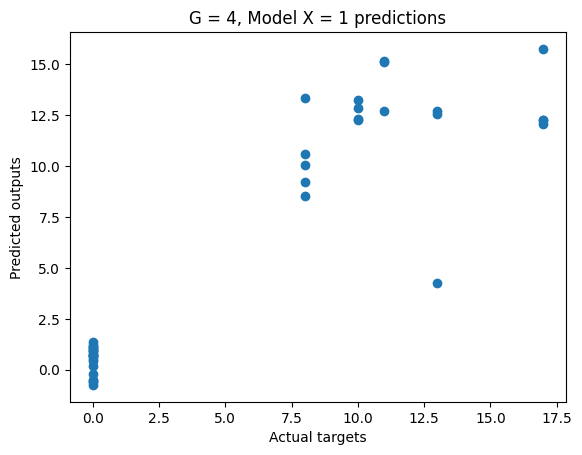

2/2 [==============================] - 0s 6ms/step
Model 2: MSE = 6.2841, R-squared = 0.8720


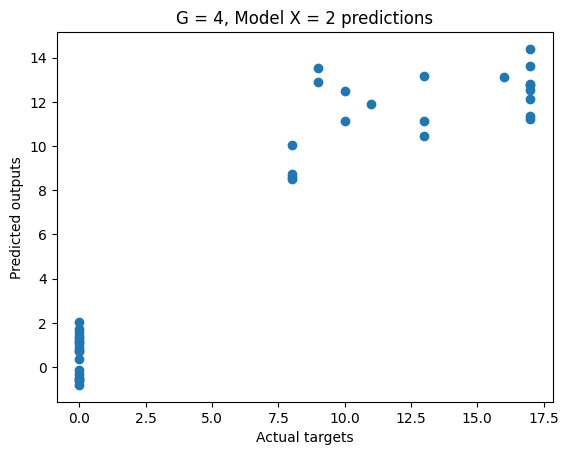

2/2 [==============================] - 0s 11ms/step
Model 3: MSE = 4.8585, R-squared = 0.8930


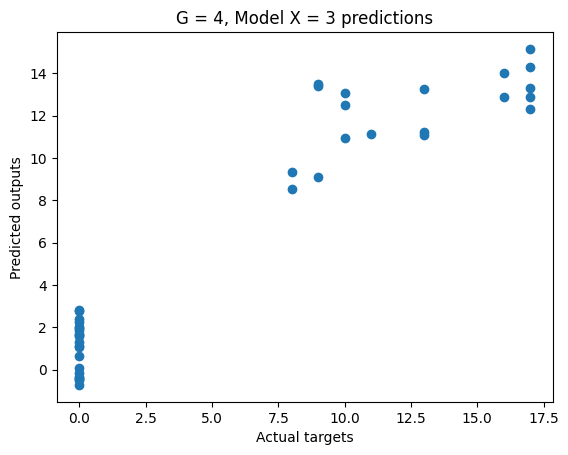

2/2 [==============================] - 0s 5ms/step
Model 4: MSE = 5.9039, R-squared = 0.8794


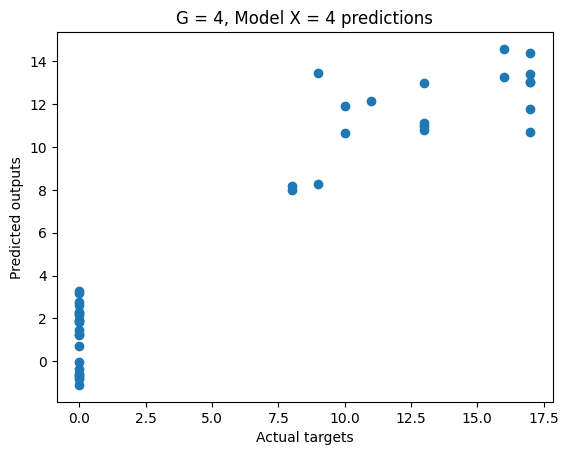

2/2 [==============================] - 0s 7ms/step
Model 5: MSE = 7.8683, R-squared = 0.8209


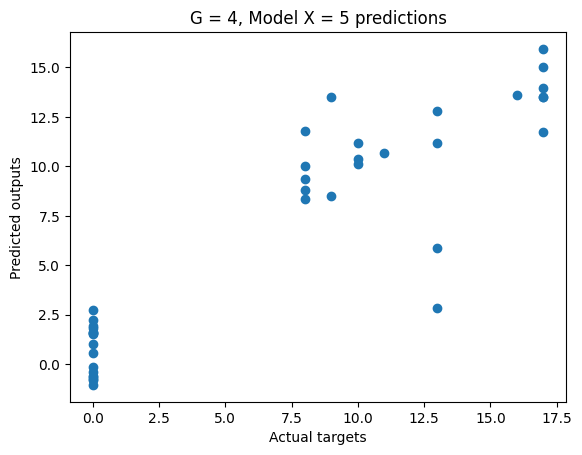

In [365]:
# Test the models for each value of x
for x in range(0, max_X):
    
    # Get the firing rates and targets for this value of x
    firing_rates_test = firing_rates_test_X[x]
    targets_test = targets_test_Y[x]

    # Reshape data
    firing_rates_test= firing_rates_test.reshape(firing_rates_test.shape[0], 1, 1000)
    targets_test = targets_test.reshape(targets_test.shape[0], 1)

    # Load the saved model for this value of x
    model = models_g8[x-1]

    # Predict the outputs for the test set
    predictions = model.predict(firing_rates_test)

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(targets_test, predictions)
    r2 = r2_score(targets_test, predictions)
    print(f'Model {x+1}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

    # Plot the predicted outputs against the actual targets
    plt.figure()
    plt.scatter(targets_test, predictions)
    plt.xlabel('Actual targets')
    plt.ylabel('Predicted outputs')
    plt.title(f'G = 4, Model X = {x+1} predictions')
    plt.show()

# Q3